# Prevendo valores do IBOV com algoritmos de machine learning

## Iniciando a coleta e análise exporatória dos dados:

### Importando as blibliotecas que serão utilizadas:

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

import utils

### Carregando o dataframe:

In [2]:
df = pd.read_csv('./Ibovespa.csv')
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,09.01.2024,131.447,132.424,132.426,131.203,"9,29M","-0,74%"
1,08.01.2024,132.427,132.023,132.498,131.015,"8,50M","0,31%"
2,05.01.2024,132.023,131.218,132.635,130.579,"9,20M","0,61%"
3,04.01.2024,131.226,132.831,132.885,131.024,"8,97M","-1,21%"
4,03.01.2024,132.834,132.697,133.576,132.250,"8,70M","0,10%"


### Analisando o dataframe:

In [3]:
df.shape

(4957, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4957 entries, 0 to 4956
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      4957 non-null   object 
 1   Último    4957 non-null   float64
 2   Abertura  4957 non-null   float64
 3   Máxima    4957 non-null   float64
 4   Mínima    4957 non-null   float64
 5   Vol.      4956 non-null   object 
 6   Var%      4957 non-null   object 
dtypes: float64(4), object(3)
memory usage: 271.2+ KB


In [5]:
df.describe()

,Último,Abertura,Máxima,Mínima
count,4957.000000,4957.000000,4957.000000,4957.000000
mean,66.905230,66.884093,67.554808,66.220636
std,28.072064,28.064641,28.260353,27.872580
min,17.604000,17.607000,18.387000,17.601000
25%,49.107000,49.102000,49.658000,48.456000
50%,60.653000,60.645000,61.299000,59.985000
75%,85.973000,85.918000,86.990000,85.197000
max,134.194000,134.194000,134.389000,133.832000


In [6]:
df.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

---
#### Observações:

*Quantidade de Entradas: 4.957 registros.*

*Intervalo Temporal: 20 anos.*

*Priodicidade dos dados: Diária.*

---
#### Colunas:

**Data:** A data da entrada do índice (tipo object, precisa ser convertido para datetime).

**Último:** O valor de fechamento do índice (float64).

**Abertura:** O valor de abertura do índice (float64).

**Máxima:** O valor máximo que o índice atingiu (float64).

**Mínima:** O valor mínimo que o índice atingiu (float64).

**Vol.:** O volume de negociações, representado como uma string que precisa de limpeza e conversão para um tipo numérico.

**Var%:** A variação percentual do índice, também como string e que precisa ser convertida para um tipo numérico.


---

### Iniciando as transformações e limpeza:

In [7]:
df['Vol.'] = df['Vol.'].apply(utils.convert_volume)
df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y')
df['Var%'] = df['Var%'].str.replace('%', '').str.replace(',', '.').astype(float)
df['Vol.'].fillna(method='ffill', inplace=True)

In [8]:
df.describe()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
count,4957,4957.000000,4957.000000,4957.000000,4957.000000,4.957000e+03,4957.000000
mean,2014-01-05 04:08:39.991930624,66.905230,66.884093,67.554808,66.220636,3.446364e+07,0.050446
min,2004-01-02 00:00:00,17.604000,17.607000,18.387000,17.601000,1.121000e+05,-14.780000
25%,2009-01-02 00:00:00,49.107000,49.102000,49.658000,48.456000,2.820000e+06,-0.840000
50%,2014-01-07 00:00:00,60.653000,60.645000,61.299000,59.985000,4.430000e+06,0.070000
75%,2019-01-14 00:00:00,85.973000,85.918000,86.990000,85.197000,1.216000e+07,0.980000
max,2024-01-09 00:00:00,134.194000,134.194000,134.389000,133.832000,9.949600e+08,14.660000
std,NaN,28.072064,28.064641,28.260353,27.872580,7.992799e+07,1.705565


In [9]:
df.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        0
Var%        0
dtype: int64

In [10]:
df.head(10)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2024-01-09,131.447,132.424,132.426,131.203,9290000.0,-0.74
1,2024-01-08,132.427,132.023,132.498,131.015,8500000.0,0.31
2,2024-01-05,132.023,131.218,132.635,130.579,9200000.0,0.61
3,2024-01-04,131.226,132.831,132.885,131.024,8970000.0,-1.21
4,2024-01-03,132.834,132.697,133.576,132.250,8700000.0,0.10
5,2024-01-02,132.697,134.186,134.195,132.095,8440000.0,-1.11
6,2023-12-28,134.185,134.194,134.389,133.832,7810000.0,-0.01
7,2023-12-27,134.194,133.523,134.195,133.328,6170000.0,0.49
8,2023-12-26,133.533,132.753,133.645,132.753,5150000.0,0.59
9,2023-12-22,132.753,132.182,133.035,132.094,8230000.0,0.43


#### Visualizando os valores de fechamento

In [11]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['y'], mode='lines', name='lines'))

# Calcular a linha de tendência
x = np.array(range(len(df)))
y = df['y'].values
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
line = slope * x + intercept

# Adicionar a linha de tendência ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=line, mode='lines', name='Linha de Tendência'))

fig.update_layout(showlegend=True)
fig.show()


KeyError: 'y'

### Análise de série temporal (Decomposição)

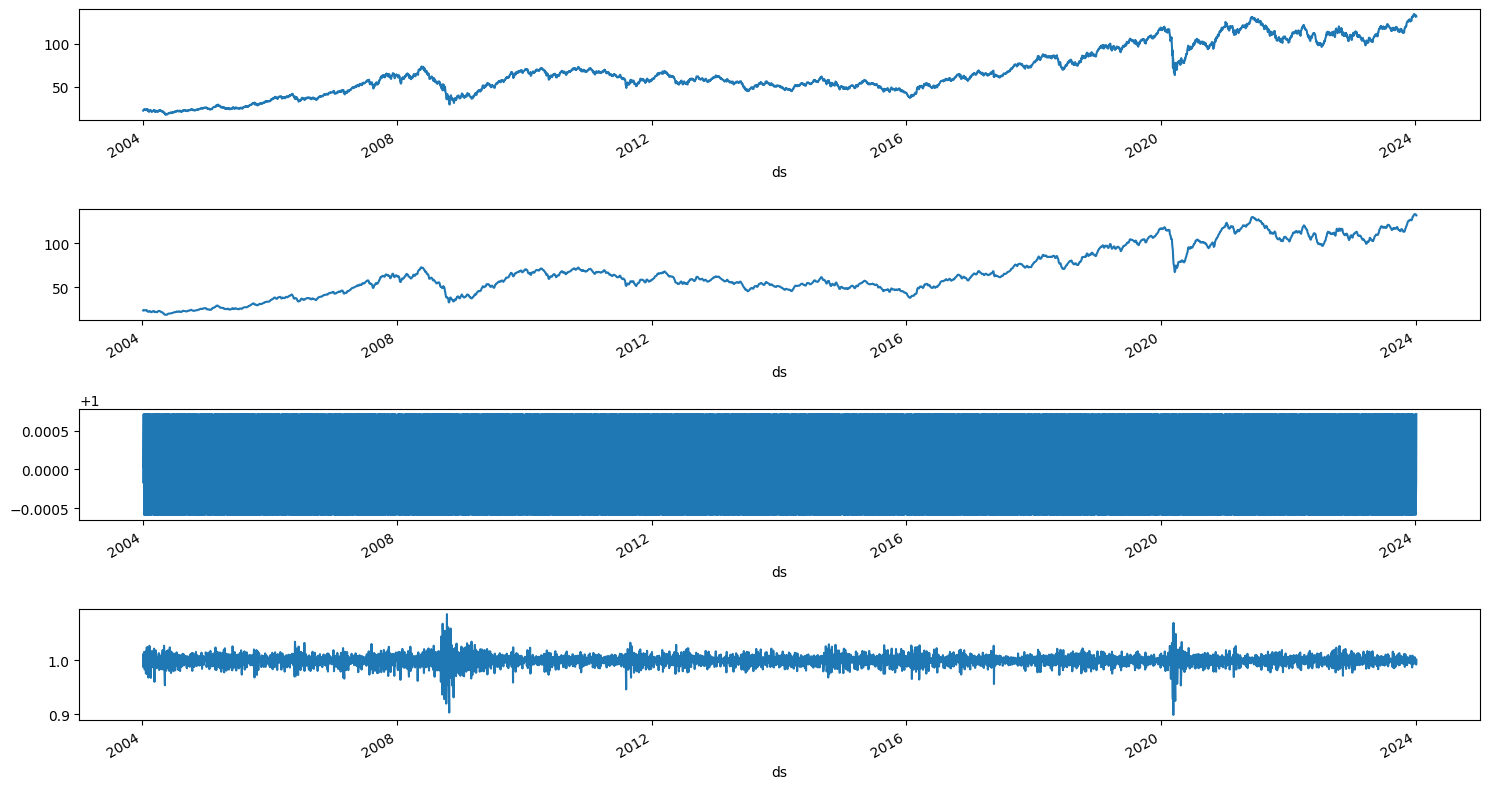

In [ ]:
seasonplot = seasonal_decompose(df, model='multiplicative', period=5) # A bolsa de valores abre 5 dias por semana
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(15,8))
seasonplot.observed.plot(ax=ax1)
seasonplot.trend.plot(ax=ax2)
seasonplot.seasonal.plot(ax=ax3)
seasonplot.resid.plot(ax=ax4)
plt.tight_layout()

## Informações importantes sobre o IBOV e análise dos pontos principais:

### Queda de 2008
A queda de 2008 está relacionada à crise financeira global desencadeada pela bolha imobiliária dos EUA, conhecida como a "crise do subprime". Os efeitos dessa crise foram sentidos em mercados financeiros ao redor do mundo, incluindo a Bovespa, que viu uma redução significativa no valor dos ativos, em linha com a aversão global ao risco e a fuga de capitais.

### Recuperação de 2009
Em 2009, houve uma recuperação no mercado de ações, incluindo o Ibovespa, em grande parte devido às medidas de estímulo econômico adotadas por governos e bancos centrais em várias partes do mundo. No Brasil, a economia começou a mostrar sinais de melhora, e os investidores recuperaram a confiança, levando a uma recuperação do valor do índice.

### Queda de 2015
A queda de 2015 pode ser atribuída a uma combinação de fatores, incluindo a desaceleração econômica do Brasil, a crise política interna e a redução dos preços das commodities. Estes eventos tiveram um impacto negativo sobre o mercado de ações brasileiro, resultando em uma performance menos favorável do Ibovespa.

### Recuperação de 2016
A recuperação do Ibovespa em 2016 foi parcialmente impulsionada pela melhoria do clima político após o impeachment da presidente Dilma Rousseff e a perspectiva de reformas econômicas propostas pelo novo governo. Além disso, a recuperação dos preços das commodities e a melhora do cenário econômico global ajudaram a impulsionar o mercado de ações.

### Queda de 2020
A queda de 2020 foi desencadeada pela pandemia de COVID-19, que causou um choque sem precedentes nas economias globais e nacionais. O Ibovespa, assim como outros índices ao redor do mundo, sofreu quedas acentuadas devido às incertezas econômicas e ao impacto das medidas de confinamento na atividade econômica.

### Recuperação de 2020
Surpreendentemente, ainda em 2020, o Ibovespa e outros mercados começaram a se recuperar rapidamente após as quedas iniciais. As respostas políticas, incluindo estímulos fiscais e monetários significativos e o progresso no desenvolvimento de vacinas, ajudaram a restaurar a confiança dos investidores e a promover uma recuperação nos preços das ações.